<a href="https://colab.research.google.com/github/tuntul17/NBA-Analysis/blob/main/NBA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#operation sys.
import os,shutil
#as ususal
import pandas as pd
import numpy as np
#to scrape
import requests as rq
import time #Just curious how will it take
#plot
from pylab import *
import plotly #this is new package for me
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns #this is also new
#ML
import torch
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Web scrapping:

To have a defined data frame, first I start with one random season so that I can define all the columns.

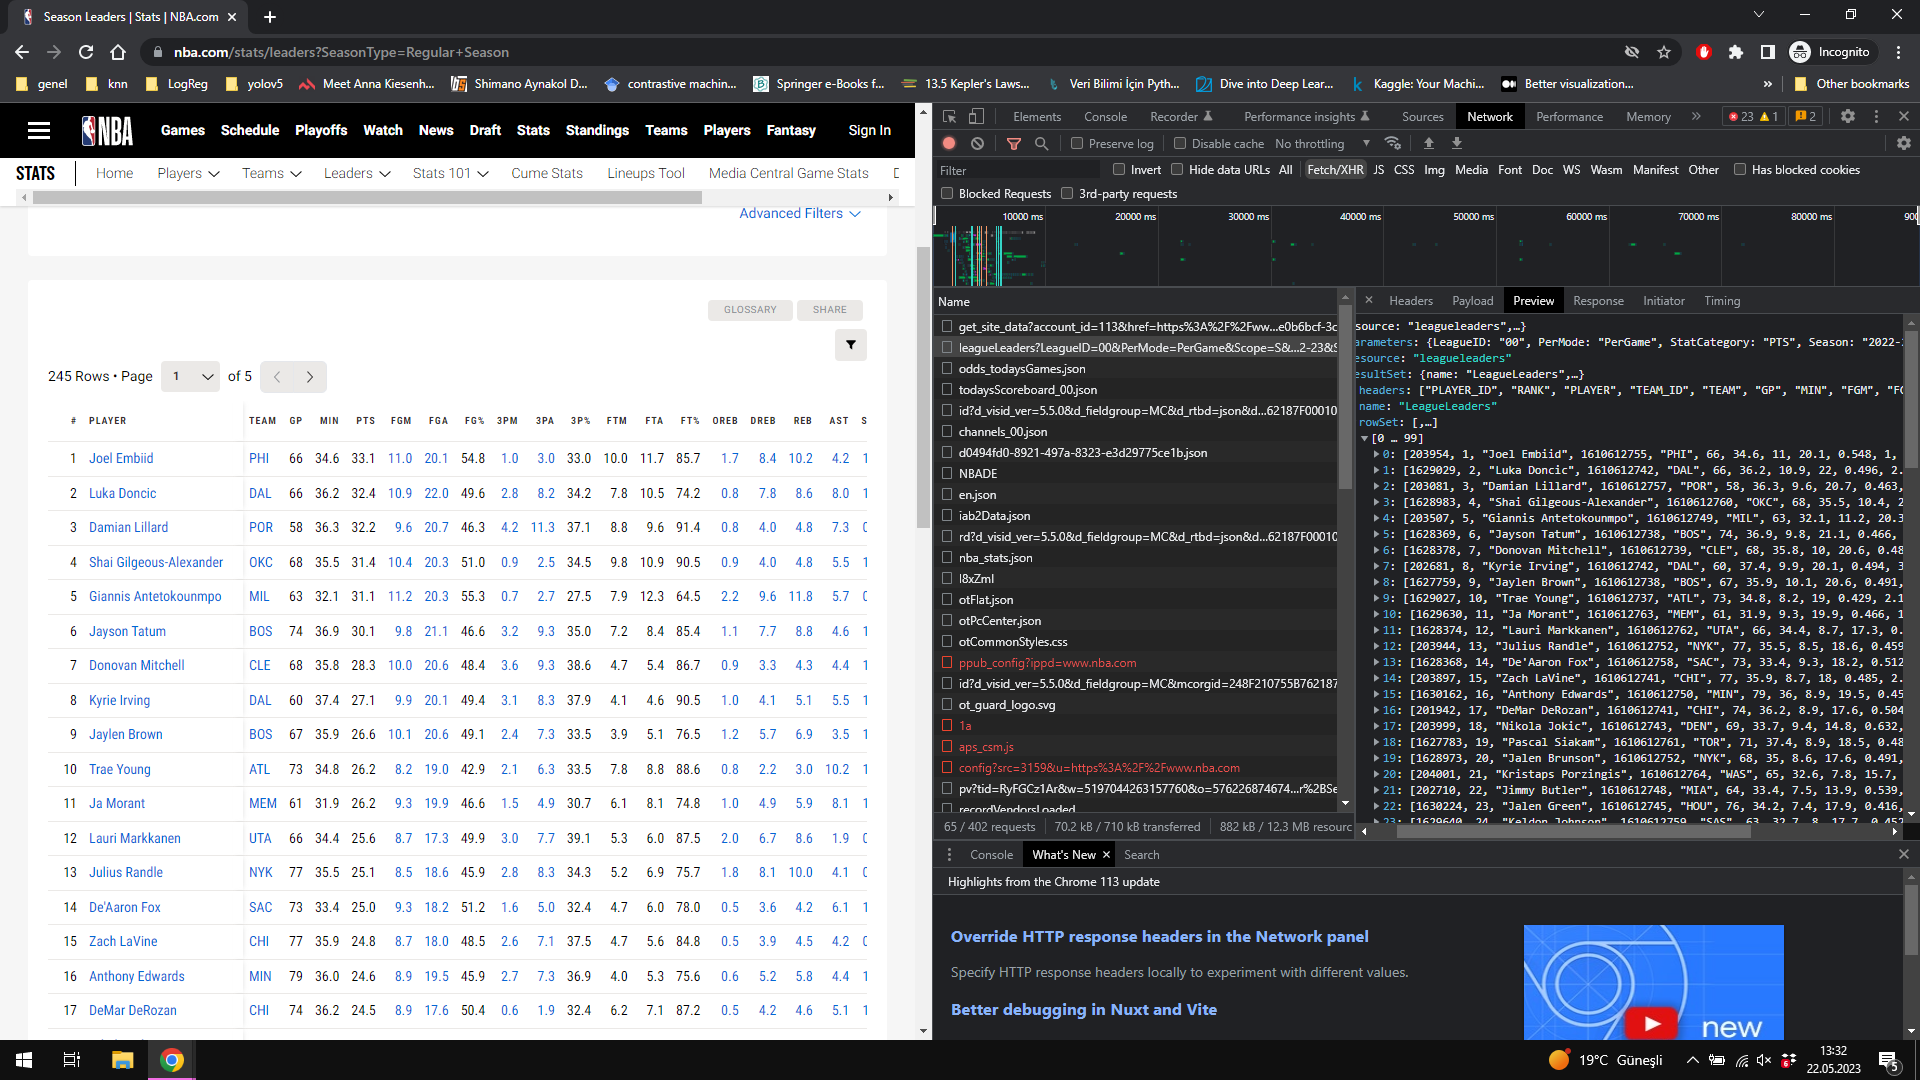

From the picture above I previewed the url below to make sure I scrape the rigth link, then from the headers part I copied the request url.

In [2]:
#before all the web scraping, I want to create a base df!
url = "https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=Rookies&Season=2020-21&SeasonType=Playoffs&StatCategory=PTS"
R = rq.get(url).json()
headers = R["resultSet"]["headers"]

Here in this block, url variable is formatted for the multiple for loops.

```
      if y-2000<10:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope={p}&Season={str(y)}-0{str(y-1999)}&SeasonType={s}&StatCategory=PTS"
      if y-2000>=10:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope={p}&Season={str(y)}-{str(y-1999)}&SeasonType={s}&StatCategory=PTS"
```



In [3]:
player = ["S","Rookies"] 
year = np.arange(2000,2022)
season_type = ["Playoffs","Regular%20Season"]
df = pd.DataFrame(columns=headers)
T = time.time() #just for curiosity 
for y in year:
  for s in season_type:
    for p in player:
      if y-2000<10:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope={p}&Season={str(y)}-0{str(y-1999)}&SeasonType={s}&StatCategory=PTS"
      if y-2000>=10:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope={p}&Season={str(y)}-{str(y-1999)}&SeasonType={s}&StatCategory=PTS"
      R = rq.get(url).json()
      #df = pd.DataFrame(R["resultSet"]['rowSet'],columns = headers)
      temp_df1 = pd.DataFrame(R["resultSet"]["rowSet"],columns= headers)
      temp_df2 = pd.DataFrame({'Year':[int(y) for i in range(len(temp_df1))],
                      "Rookie":[p for i in range(len(temp_df1))],
                      'Season_type':[s for i in range(len(temp_df1))]})
      temp3 = pd.concat([temp_df2,temp_df1],axis=1)
      df = pd.concat([temp3,df],axis=0)
      
df['Season_type'].replace("Regular%20Season","Regular Season",inplace=True)
df["Rookie"].replace("S","Non-Rookie",inplace=True)
df["Rookie"].replace("Rookies","Rookie",inplace=True)
print(f"web scraping took {round(time.time()-T,2)} second ")
T1 = time.time()
df.to_excel("RAW_20_NBA.xlsx",index=False)
print(f"saving as a xlsx file took {round(time.time()-T1,2)} second")

web scraping took 52.19 second 
saving as a xlsx file took 10.15 second


After this block of code main data frame is created by scraping from nba's website.

* **This is raw data**
* Move this file to drive just in case!

In [4]:
shutil.copy("/content/RAW_20_NBA.xlsx","/content/drive/MyDrive/Colab Notebooks")

'/content/drive/MyDrive/Colab Notebooks/RAW_20_NBA.xlsx'

# Data Cleaning:

In [5]:
rawData = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/RAW_20_NBA.xlsx")
#rawData = pd.read_excel("/content/RAW_20_NBA.xlsx")

In [6]:
rawData.sample(5)

,Year,Rookie,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
5132,2016,Non-Rookie,Playoffs,203501,77,Tim Hardaway Jr.,1610612737,ATL,6,200,...,16,7,3,0,10,13,77,31,0.70,0.30
242,2021,Non-Rookie,Regular Season,201580,153,JaVale McGee,1610612756,PHX,74,1172,...,496,42,22,81,98,181,680,1009,0.43,0.22
15266,2001,Non-Rookie,Regular Season,383,224,Kendall Gill,1610612748,MIA,65,1415,...,184,100,44,8,55,140,372,373,1.82,0.80
5068,2016,Non-Rookie,Playoffs,202330,13,Gordon Hayward,1610612762,UTA,11,411,...,67,37,10,3,24,23,265,248,1.54,0.42
13327,2004,Non-Rookie,Regular Season,1893,430,Aleksandar Radojevic,1610612762,UTA,12,128,...,28,6,0,2,15,32,19,24,0.40,0.00


First drop the unnecessary columns:

In [7]:
rawData.drop(columns=["RANK","TEAM_ID","PLAYER_ID"],inplace=True)
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16398 entries, 0 to 16397
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         16398 non-null  int64  
 1   Rookie       16398 non-null  object 
 2   Season_type  16398 non-null  object 
 3   PLAYER       16398 non-null  object 
 4   TEAM         16398 non-null  object 
 5   GP           16398 non-null  int64  
 6   MIN          16398 non-null  int64  
 7   FGM          16398 non-null  int64  
 8   FGA          16398 non-null  int64  
 9   FG_PCT       16398 non-null  float64
 10  FG3M         16398 non-null  int64  
 11  FG3A         16398 non-null  int64  
 12  FG3_PCT      16398 non-null  float64
 13  FTM          16398 non-null  int64  
 14  FTA          16398 non-null  int64  
 15  FT_PCT       16398 non-null  float64
 16  OREB         16398 non-null  int64  
 17  DREB         16398 non-null  int64  
 18  REB          16398 non-null  int64  
 19  AST 

In [8]:
rawData.TEAM.unique()

array(['ORL', 'HOU', 'TOR', 'DET', 'CLE', 'SAC', 'NOP', 'IND', 'DEN',
       'CHI', 'OKC', 'GSW', 'WAS', 'BKN', 'MEM', 'LAL', 'POR', 'LAC',
       'MIA', 'SAS', 'NYK', 'UTA', 'MIL', 'CHA', 'PHX', 'PHI', 'BOS',
       'ATL', 'MIN', 'DAL', 'NOH', 'NJN', 'SEA', 'NOK', 'CHH', 'VAN'],
      dtype=object)

Over the years some teams are added or changed its name so it needs to be updated.

In [9]:
rawData['TEAM'].replace(to_replace=["NOP","NOH","NOK"],value = "NOP", inplace = True) #New Orleans Hornets will be replaced w/ New Orleans Pelicans (Really?)
rawData['TEAM'].replace(to_replace=["BKN","NJN"],value = "BKN", inplace = True) #New Jersey Nets will be replaced w/ Brooklyn Nets
rawData["TEAM"].replace(to_replace=["SEA"],value = "OKC",inplace = True) #Seattle Supersonics ==> Oklahama City Thunder in '08
rawData["TEAM"].replace(to_replace=["VAN"],value = "MEM",inplace = True) #Vancouver Grizzlies ==> Memphis Grizzlies in '01
rawData["TEAM"].replace(to_replace=["CHH"],value = "CHA",inplace = True) #Charlotte Bobcats to Charlotte Hornets

Also, in a player's rookie year it has two rows as labelled both Rookie and Non-Rookie

In [10]:
rawData.drop_duplicates(subset=rawData.columns[2:],keep="first",inplace=True) #Rookie player had two stats with two labels (Rooki/Non-Rookie)
rawData = rawData[rawData["GP"]>=4]

To make sure it worked, pick a random player.

In [11]:
rawData[rawData["PLAYER"]=="Duncan Robinson"] #example player

,Year,Rookie,Season_type,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
199,2021,Non-Rookie,Regular Season,Duncan Robinson,MIA,79,2043,290,726,0.399,...,203,129,42,14,60,201,863,745,2.15,0.70
793,2021,Non-Rookie,Playoffs,Duncan Robinson,MIA,13,159,25,57,0.439,...,23,5,4,1,3,22,73,70,1.67,1.33
1080,2020,Non-Rookie,Regular Season,Duncan Robinson,MIA,72,2262,315,717,0.439,...,250,127,43,20,81,181,942,886,1.57,0.53
1699,2020,Non-Rookie,Playoffs,Duncan Robinson,MIA,4,100,11,29,0.379,...,11,3,3,0,4,13,41,35,0.75,0.75
2006,2019,Non-Rookie,Regular Season,Duncan Robinson,MIA,73,2166,323,687,0.470,...,232,102,35,19,70,193,983,932,1.46,0.50
2519,2019,Non-Rookie,Playoffs,Duncan Robinson,MIA,21,600,75,176,0.426,...,58,38,14,6,16,65,245,239,2.38,0.88
2775,2018,Rookie,Regular Season,Duncan Robinson,MIA,15,161,18,46,0.391,...,19,5,5,0,4,11,50,45,1.25,1.25


It works.

Seperate Playoff & Regular Season data for later.

In [12]:
playoff_data = rawData[rawData["Season_type"]=="Playoffs"]
Regular_data = rawData[rawData["Season_type"]=="Regular Season"]

In [13]:
#important columns:
col = ["GP","MIN","FGM","FGA","FG3M","FG3A","FTM","FTA","OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS"]
#the other columns will create a chaos as they are percentage stats

Other columns will cause a problem in the future, the col list is essantial columns others can be produced from these.

# Guess if a player is a rookie:

First let's change the data frame little bit for our needs

In [14]:
#groupby 
rok = rawData.groupby(["Rookie","PLAYER","Year"])[col].sum().reset_index()
rok.sample(10)

,Rookie,PLAYER,Year,GP,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
5189,Non-Rookie,Malik Beasley,2021,85,2095,351,894,248,662,54,66,28,219,247,120,45,13,50,97,1004
3595,Non-Rookie,Jarron Collins,2007,75,722,36,85,0,1,46,74,43,79,122,38,11,7,22,108,118
7529,Non-Rookie,Tim Duncan,2014,84,2477,472,909,2,8,249,345,189,593,782,253,72,161,138,191,1195
8237,Non-Rookie,Zydrunas Ilgauskas,2002,81,2432,495,1122,0,5,400,512,240,371,611,127,56,152,210,274,1390
1311,Non-Rookie,Chris Childs,2000,89,2239,172,425,47,142,80,94,26,214,240,433,71,18,191,290,471
6481,Non-Rookie,Rasual Butler,2014,75,1505,218,517,91,235,53,67,27,170,197,63,29,22,48,98,580
3711,Non-Rookie,Jawad Williams,2010,26,391,41,126,13,45,9,12,7,41,48,22,9,3,16,34,104
4809,Non-Rookie,Kyle Lowry,2021,73,2428,301,713,157,436,163,193,36,282,318,521,79,24,187,206,922
4079,Non-Rookie,John Thomas,2005,24,183,9,21,0,0,4,6,14,16,30,4,6,3,13,32,22
9435,Rookie,Quinn Cook,2016,14,187,33,66,11,26,2,5,1,6,7,26,4,0,13,13,79


In [15]:
#now add back to percentages to the 
rok["FG%"] = rok["FGM"]/rok["FGA"]
rok["3PT%"] = rok["FG3M"]/rok["FG3A"]
rok["FT%"] = rok["FTM"]/rok["FTA"]
rok["FG3A%"] = rok["FG3A"]/rok["FGA"]

rok["PTS/FGA"] = rok["PTS"]/rok["FGA"]
rok["FG3M/FGM"] = rok["FG3M"]/rok["FGM"]
rok["FTA/FGA"] = rok["FTA"]/rok["FGA"]
rok["TRU%"] = 0.5*rok["PTS"]/(rok["FGA"]+0.475*rok["FTA"])
rok["AST/TOV"] = rok["AST"]/rok["TOV"]


There might be some 0/0 division so fill those with 0

In [16]:
rok.fillna(0,inplace=True)
rok

,Rookie,PLAYER,Year,GP,MIN,FGM,FGA,FG3M,FG3A,FTM,...,PTS,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST/TOV
0,Non-Rookie,A.C. Green,2000,82,1411,144,324,0,6,79,...,367,0.444444,0.000000,0.711712,0.018519,1.132716,0.000000,0.342593,0.487093,0.866667
1,Non-Rookie,A.J. Guyton,2001,45,604,88,244,46,123,22,...,244,0.360656,0.373984,0.814815,0.504098,1.000000,0.522727,0.110656,0.475032,2.189189
2,Non-Rookie,AJ Price,2010,55,875,127,355,48,165,63,...,365,0.357746,0.290909,0.692308,0.464789,1.028169,0.377953,0.256338,0.458284,1.950000
3,Non-Rookie,AJ Price,2011,48,575,60,176,26,88,28,...,174,0.340909,0.295455,0.800000,0.500000,0.988636,0.433333,0.198864,0.451655,2.718750
4,Non-Rookie,AJ Price,2012,57,1278,161,413,70,200,49,...,441,0.389831,0.350000,0.790323,0.484262,1.067797,0.434783,0.150121,0.498361,3.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,Rookie,Ziaire Williams,2021,72,1514,214,476,87,278,55,...,570,0.449580,0.312950,0.808824,0.584034,1.197479,0.406542,0.142857,0.560693,1.627907
9757,Rookie,Zion Williamson,2019,24,668,210,360,6,14,114,...,540,0.583333,0.428571,0.640449,0.038889,1.500000,0.028571,0.494444,0.607356,0.847458
9758,Rookie,Zoran Dragic,2014,16,75,11,30,3,14,3,...,28,0.366667,0.214286,0.600000,0.466667,0.933333,0.272727,0.166667,0.432432,1.000000
9759,Rookie,Zoran Planinic,2003,55,486,53,131,9,33,39,...,154,0.404580,0.272727,0.629032,0.251908,1.175573,0.169811,0.473282,0.479900,1.842105


Prepare the train and test data:

In [17]:
Y = np.array(rok["Rookie"])
#this may be stupid: (Rookie ==1, Non-Rookie == 0)
for i in range(len(Y)):
  if Y[i] == "Rookie":
    Y[i] =1
  else:
    Y[i] = 0

X = np.array(rok[rok.columns[3:]])
where_are_NaNs = isnan(X)
X[where_are_NaNs] = 0
print(X.shape)

(9761, 26)


Split the test and training data.

In [18]:
xtr,xts,ytr,yts = train_test_split(X,Y,train_size = 0.8,shuffle=True,random_state=42)
xtr=xtr.astype('int')
xts=xts.astype('int')
ytr = ytr.astype("int")
yts = yts.astype('int')

## Guess w/ sklearn knn:

In [19]:
#knn model:
knn = KNeighborsClassifier()

In [20]:
#fit the model:
knn.fit(xtr,ytr)

KNeighborsClassifier()

In [21]:
y_pred = knn.predict(xts)

In [22]:
lab = ["Non-Rookie","Rookie"]
Report = classification_report(yts,y_pred,target_names = lab) 
acc = sk.metrics.accuracy_score(yts,y_pred,normalize=False)
print("total test value: ",len(yts))
print("total correct ans: ", acc)
print(Report)

total test value:  1953
total correct ans:  1604
              precision    recall  f1-score   support

  Non-Rookie       0.86      0.95      0.90      1650
      Rookie       0.33      0.14      0.20       303

    accuracy                           0.82      1953
   macro avg       0.59      0.54      0.55      1953
weighted avg       0.77      0.82      0.79      1953



Without any optimization knn can not differentiate rookies
but it can find non-rookies
> Time to optimize a little bit


In [23]:
#First get the hyperparameters
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

***REMINDER:***

**PLEASE DON'T RUN THIS CODE EVERY TIME**

In [24]:
#this may take a lot of time.
from sklearn.model_selection import GridSearchCV
T = time.time()
#hyperparameter range:
n_neighbors = list(range(21,41,2)) 
weights = ["uniform","distance"]
algorithm = ["auto","ball_tree","brute"]
leaf_size = list(range(1,11))
p = [1,2]

hyperparameters= dict(leaf_size=leaf_size,n_neighbors= n_neighbors,algorithm= algorithm,weights=weights,p=p)

#Create a second model to optimize:
knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2,hyperparameters,cv=2)
#use optimum parameters to get best result for fitting
best_model = clf.fit(xtr,ytr)
End_time = time.time()
#print the optimum parameters:
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print("Best weights: ",best_model.best_estimator_.get_params()["weights"])
print("Best algorithm: ",best_model.best_estimator_.get_params()["algorithm"])

#predict:
y_pred2 = best_model.predict(xts)

report2 = classification_report(yts,y_pred2,target_names=lab)


Best leaf_size: 2
Best p: 1
Best n_neighbors: 35
Best weights:  uniform
Best algorithm:  ball_tree


Above it gives us the optimized parameters to set.

In [25]:
print(f"Total time: {round((End_time-T)/60,2)} min")
print(report2)
print(confusion_matrix(yts,y_pred2))

Total time: 16.82 min
              precision    recall  f1-score   support

  Non-Rookie       0.85      0.99      0.91      1650
      Rookie       0.40      0.03      0.05       303

    accuracy                           0.84      1953
   macro avg       0.62      0.51      0.48      1953
weighted avg       0.78      0.84      0.78      1953

[[1638   12]
 [ 295    8]]


After the optimizitation this looks better even if it is not much.

# Plots of stats over the last 20 year:

In [26]:
#del yearly

In [27]:
yearly = Regular_data.groupby("Year")[col].sum().reset_index()

In [28]:
playly = playoff_data.groupby("Year")[col].sum().reset_index()

As a fan of nba basketball, I know that over the years number of the possitions has increased. I want to know how much changed year to year.
 
* For this I need to define an estimated number of possitions because I don't have this information directly. 
* I also want to see the difference between the playoff games and regular seasons.
* **0.44** is just a common guess
  *  A better approach would be a discrete change over the years for this number but neither it is consistent nor easy to fit.

In [29]:
playly["POSS_es"] = playly["FGA"] -playly["OREB"] + playly["TOV"] +0.44*playly["FTA"] 
playly=playly[list(playly.columns[0:2])+["POSS_es"]+list(playly.columns[2:-1])]

In [30]:
yearly["POSS_es"] = yearly["FGA"] -yearly["OREB"] + yearly["TOV"] +0.44*yearly["FTA"] 
#0.44 is just an estimation, this also does not include some type of turnovers such as shot clock violation.
yearly=yearly[list(yearly.columns[0:2])+["POSS_es"]+list(yearly.columns[2:-1])]

True shooting is defined as it is.

In [31]:
yearly["FG%"] = yearly["FGM"]/yearly["FGA"]
yearly["3PT%"] = yearly["FG3M"]/yearly["FG3A"]
yearly["FT%"] = yearly["FTM"]/yearly["FTA"]
yearly["AST%"] = yearly["AST"]/yearly["FGM"]
yearly["FG3A%"] = yearly["FG3A"]/yearly["FGA"]
yearly["PTS/FGA"] = yearly["PTS"]/yearly["FGA"]
yearly["FG3M/FGM"] = yearly["FG3M"]/yearly["FGM"]
yearly["FTA/FGA"] = yearly["FTA"]/yearly["FGA"]
yearly["TRU%"] = 0.5*yearly["PTS"]/(yearly["FGA"]+0.475*yearly["FTA"])
yearly["AST/TOV"] = yearly["AST"]/yearly["TOV"]


In [32]:
playly["FG%"] = playly["FGM"]/playly["FGA"]
playly["3PT%"] = playly["FG3M"]/playly["FG3A"]
playly["FT%"] = playly["FTM"]/playly["FTA"]
playly["AST%"] = playly["AST"]/playly["FGM"]
playly["FG3A%"] = playly["FG3A"]/playly["FGA"]
playly["PTS/FGA"] = playly["PTS"]/playly["FGA"]
playly["FG3M/FGM"] = playly["FG3M"]/playly["FGM"]
playly["FTA/FGA"] = playly["FTA"]/playly["FGA"]
playly["TRU%"] = 0.5*playly["PTS"]/(playly["FGA"]+0.475*playly["FTA"])
playly["AST/TOV"] = playly["AST"]/playly["TOV"]

In [33]:
playly.columns

Index(['Year', 'GP', 'POSS_es', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'FG%', '3PT%', 'FT%', 'AST%', 'FG3A%', 'PTS/FGA', 'FG3M/FGM', 'FTA/FGA',
       'TRU%', 'AST/TOV'],
      dtype='object')

In [34]:
play_per48 = playly.copy()
for col in play_per48.columns[2:18]:
  play_per48[col]=(play_per48[col]/play_per48["MIN"])*48*5

play_per48.drop(columns="MIN",inplace=True)

In [35]:
changed_per48_df = yearly.copy()
for col in changed_per48_df.columns[2:18]:
  changed_per48_df[col] = (changed_per48_df[col]/changed_per48_df["MIN"])*48*5
changed_per48_df.drop(columns="MIN",inplace = True)
changed_per48_df

,Year,GP,POSS_es,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,...,FG%,3PT%,FT%,AST%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST/TOV
0,2000,23949,93.169452,84858.0,191639.0,11524.0,32594.0,44198.0,59127.0,28514.0,...,0.442801,0.353562,0.747510,0.610054,0.170080,1.176368,0.135803,0.308533,0.513002,1.512402
1,2001,23882,92.691819,85981.0,193188.0,12401.0,35069.0,42606.0,56626.0,29088.0,...,0.445064,0.353617,0.752411,0.606064,0.181528,1.174861,0.144230,0.293113,0.515639,1.587171
2,2002,23914,92.990701,84930.0,192077.0,12200.0,34909.0,44020.0,58093.0,28649.0,...,0.442166,0.349480,0.757751,0.601990,0.181745,1.177028,0.143648,0.302446,0.514587,1.506926
3,2003,23866,92.268024,83238.0,189750.0,12320.0,35488.0,43261.0,57552.0,28742.0,...,0.438672,0.347160,0.751685,0.608508,0.187025,1.170261,0.148009,0.303304,0.511447,1.496514
4,2004,24930,93.025812,88393.0,197533.0,13772.0,38728.0,48442.0,64066.0,29533.0,...,0.447485,0.355608,0.756126,0.592004,0.196058,1.209924,0.155804,0.324331,0.524205,1.535926
5,2005,24886,92.352213,88130.0,194234.0,14083.0,39304.0,48204.0,64673.0,27479.0,...,0.453731,0.358310,0.745350,0.575196,0.202354,1.228142,0.159798,0.332964,0.530214,1.497238
6,2006,25062,93.729033,89841.0,196012.0,14925.0,41664.0,48239.0,64121.0,27346.0,...,0.458344,0.358223,0.752312,0.582652,0.212558,1.238934,0.166127,0.327128,0.536156,1.466644
7,2007,24874,94.219689,91664.0,200488.0,16124.0,44544.0,46346.0,61359.0,27550.0,...,0.457204,0.361979,0.755325,0.583708,0.222178,1.225999,0.175903,0.306048,0.535196,1.607336
8,2008,24603,93.516913,91281.0,198972.0,16344.0,44555.0,46887.0,60832.0,27150.0,...,0.458763,0.366828,0.770762,0.565024,0.223926,1.235315,0.179052,0.305731,0.539334,1.561253
9,2010,25128,93.874695,91614.0,199751.0,15886.0,44302.0,45750.0,59922.0,26839.0,...,0.458641,0.358584,0.763493,0.577161,0.221786,1.225846,0.173401,0.299983,0.536479,1.581977


In [36]:
changed_per48_df.columns

Index(['Year', 'GP', 'POSS_es', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%',
       '3PT%', 'FT%', 'AST%', 'FG3A%', 'PTS/FGA', 'FG3M/FGM', 'FTA/FGA',
       'TRU%', 'AST/TOV'],
      dtype='object')

* Visiualize some interesting change over the years: 

In [37]:
import plotly.express as px

fig = px.imshow(changed_per48_df.corr())
fig.show()


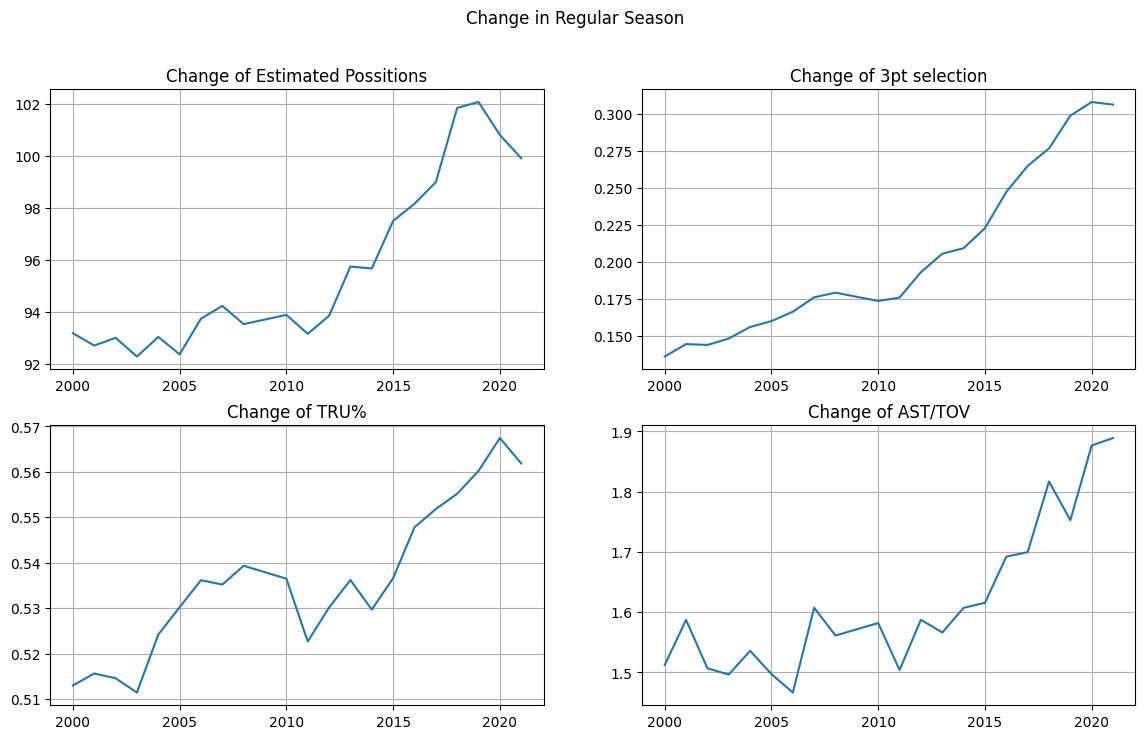

In [38]:
fig,ax = subplots(2,2,figsize=(14,8))



ax[0,0].plot(changed_per48_df["Year"],changed_per48_df["POSS_es"])
ax[0,0].title.set_text("Change of Estimated Possitions")
ax[0,1].plot(changed_per48_df["Year"],changed_per48_df["FG3M/FGM"])
ax[0,1].title.set_text("Change of 3pt selection")
ax[1,0].plot(changed_per48_df["Year"],changed_per48_df["TRU%"])
ax[1,0].title.set_text("Change of TRU%")
ax[1,1].plot(changed_per48_df["Year"],changed_per48_df["AST/TOV"])
ax[1,1].title.set_text("Change of AST/TOV")
for i in range(0,2):
  for j in range(0,2):
    ax[i,j].grid(True)
fig.suptitle("Change in Regular Season")
show()

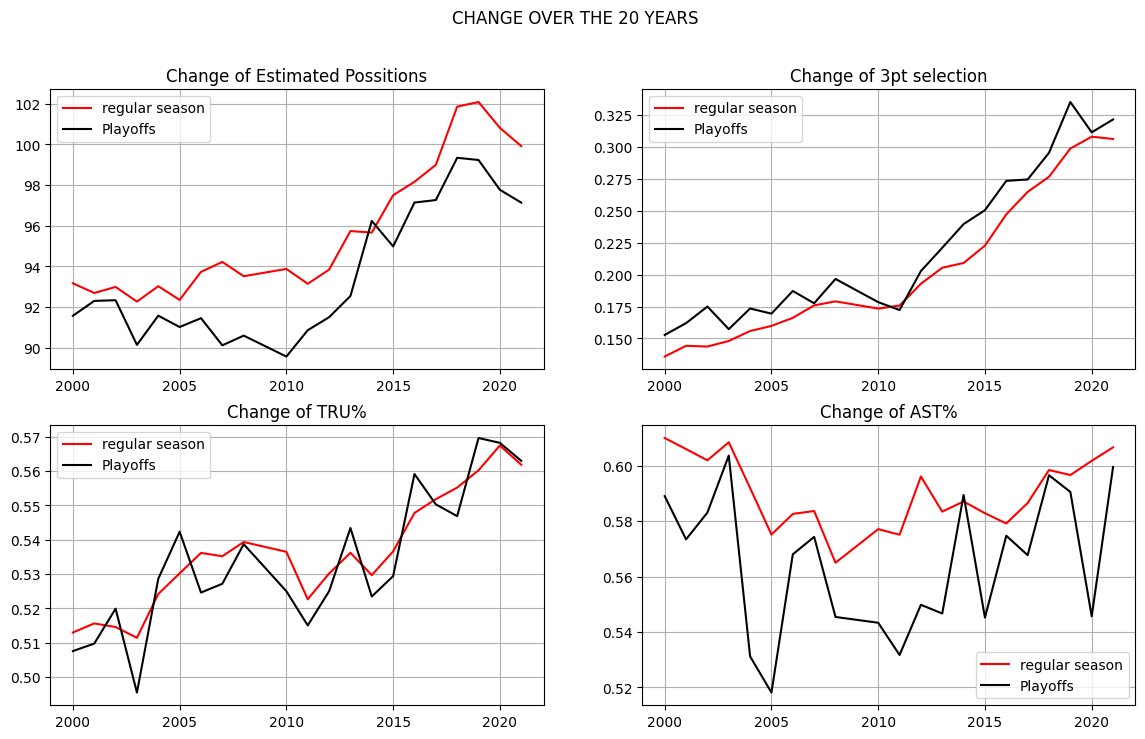

In [39]:
fig,ax = subplots(2,2,figsize=(14,8))
fig.suptitle("CHANGE OVER THE 20 YEARS")
ax[0,0].plot(changed_per48_df["Year"],changed_per48_df["POSS_es"],label = "regular season",c = 'r')
ax[0,0].plot(play_per48["Year"],play_per48["POSS_es"],label="Playoffs",c = "k")
ax[0,0].title.set_text("Change of Estimated Possitions")
ax[0,1].plot(changed_per48_df["Year"],changed_per48_df["FG3M/FGM"],label = "regular season",c = 'r')
ax[0,1].plot(play_per48["Year"],play_per48["FG3M/FGM"],label="Playoffs",c = "k")
ax[0,1].title.set_text("Change of 3pt selection")
ax[1,0].plot(changed_per48_df["Year"],changed_per48_df["TRU%"],label = "regular season",c = 'r')
ax[1,0].plot(play_per48["Year"],play_per48["TRU%"],label="Playoffs",c = "k")
ax[1,0].title.set_text("Change of TRU%")
ax[1,1].plot(changed_per48_df["Year"],changed_per48_df["AST%"],label = "regular season",c = 'r')
ax[1,1].plot(play_per48["Year"],play_per48["AST%"],label="Playoffs",c = "k")
ax[1,1].title.set_text("Change of AST%")
for i in range(0,2):
  for j in range(0,2):
    ax[i,j].grid(True)
    ax[i,j].legend()

show()

These plots are accurate as it can be but looks weird, I want to smooth those line even if it means less accurate results. After all, It does not have to be that specific, just an overall thought would be enough!

Smooth those lines:

In [40]:
def moving_avarage_smoothing(X,k):
	S = np.zeros(X.shape[0])
	for t in range(X.shape[0]):
		if t < k:
			S[t] = np.mean(X[:t+1])
		else:
			S[t] = np.sum(X[t-k:t])/k
	return S
km= 5
smt_3per_pl = moving_avarage_smoothing(play_per48["FG3M/FGM"],km)
smt_3per_reg = moving_avarage_smoothing(changed_per48_df["FG3M/FGM"],km)

An example: 

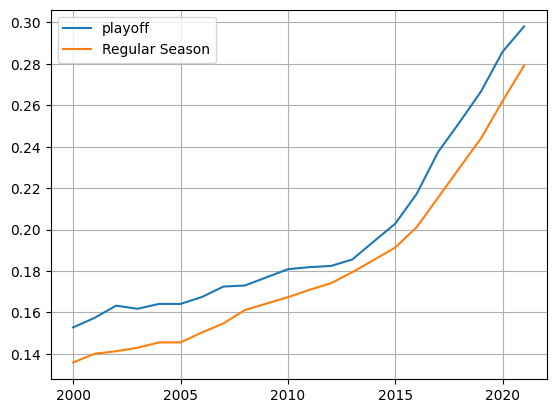

In [41]:
plot(play_per48["Year"],smt_3per_pl,label="playoff")
plot(changed_per48_df["Year"],smt_3per_reg,label="Regular Season")
legend()
grid(True)
show()

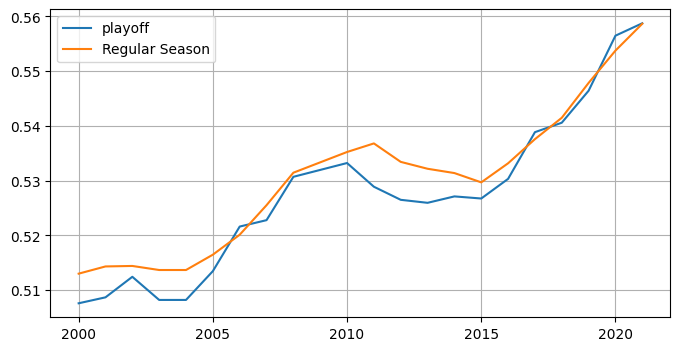

In [42]:
k1 = 4
k2 = 4
smt_tru_pl = moving_avarage_smoothing(play_per48["TRU%"],k1)
smt_tru_reg = moving_avarage_smoothing(changed_per48_df["TRU%"],k2)
fig = figure(figsize=(8,4))
plot(play_per48["Year"],smt_tru_pl,label="playoff")
plot(changed_per48_df["Year"],smt_tru_reg,label="Regular Season")
legend()
grid(True)
show()

Put them all together: 

In [43]:
#for estimated position:
k_pos_reg = 2
k_pos_pl = 3
smt_pos_reg = moving_avarage_smoothing(changed_per48_df["POSS_es"],k_pos_reg)
smt_pos_pl = moving_avarage_smoothing(play_per48["POSS_es"],k_pos_pl)
#for FG3M/FGM:
k_3_reg = 1
k_3_pl = 3
smt_3_reg = moving_avarage_smoothing(changed_per48_df["FG3M/FGM"],k_3_reg)
smt_3_pl = moving_avarage_smoothing(play_per48["FG3M/FGM"],k_3_pl)
#for TRU%:
kTRU_reg = 3
kTRU_pl = 4
smt_TRU_reg = moving_avarage_smoothing(changed_per48_df["TRU%"],kTRU_reg)
smt_TRU_pl = moving_avarage_smoothing(play_per48["TRU%"],kTRU_pl)
#for AST%:
kast_reg = 5
kast_pl = 6
smt_ast_reg = moving_avarage_smoothing(changed_per48_df["AST%"],kast_reg)
smt_ast_pl =  moving_avarage_smoothing(play_per48["AST%"],kast_pl)

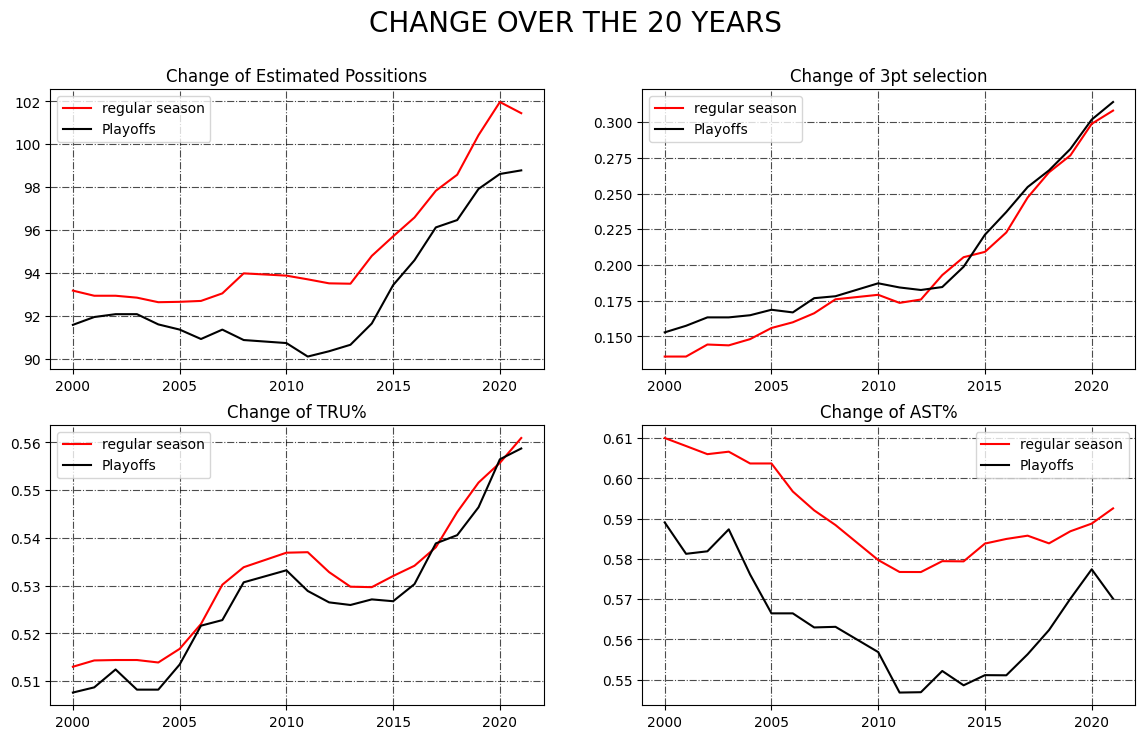

In [52]:
fig,ax = subplots(2,2,figsize=(14,8))
fig.suptitle("CHANGE OVER THE 20 YEARS",fontsize = 20)
ax[0,0].plot(changed_per48_df["Year"],smt_pos_reg,label = "regular season",c = 'r')
ax[0,0].plot(play_per48["Year"],smt_pos_pl,label="Playoffs",c = "k")
ax[0,0].title.set_text("Change of Estimated Possitions")
ax[0,1].plot(changed_per48_df["Year"],smt_3_reg,label = "regular season",c = 'r')
ax[0,1].plot(play_per48["Year"],smt_3_pl,label="Playoffs",c = "k")
ax[0,1].title.set_text("Change of 3pt selection")
ax[1,0].plot(changed_per48_df["Year"],smt_TRU_reg,label = "regular season",c = 'r')
ax[1,0].plot(play_per48["Year"],smt_TRU_pl,label="Playoffs",c = "k")
ax[1,0].title.set_text("Change of TRU%")
ax[1,1].plot(changed_per48_df["Year"],smt_ast_reg,label = "regular season",c = 'r')
ax[1,1].plot(play_per48["Year"],smt_ast_pl,label="Playoffs",c = "k")
ax[1,1].title.set_text("Change of AST%")
for i in range(0,2):
  for j in range(0,2):
    ax[i,j].grid(True,linestyle="-.",alpha=0.7,c = "k")
    ax[i,j].legend()
#title("PER 48 MINUTES")
show()

So based on the graphic above, we can deduce that,
*  In playoff games teams tend to reduce the pace, and teams plays less team ball.
* Another take would be, over the years, teams star to take more 3 point shots and also their shot selection got smarter overall (It can be seen from the True shot statistic)

In [45]:
#double exponantial smoothing:
def double_exponential_smoothing(X,alpha,beta):
	S,A,B = (np.zeros( X.shape[0] ) for i in range(3))
	S[0] = X[0]
	B[0] = X[1] - X[0]
	for t in range(1,X.shape[0]):
		A[t] = alpha * X[t] + (1- alpha) * S[t-1]
		B[t] = beta * (A[t] - A[t-1]) + (1 - beta) * B[t-1]
		S[t] = A[t] + B[t]
	return S

In [46]:
alpha1, beta1 = 0.3,0.05
alpha2,beta2 = 0.26, 0.07
exp_reg = double_exponential_smoothing(changed_per48_df["AST%"],alpha1,beta1)
exp_pl = double_exponential_smoothing(play_per48["AST%"],alpha2,beta2)

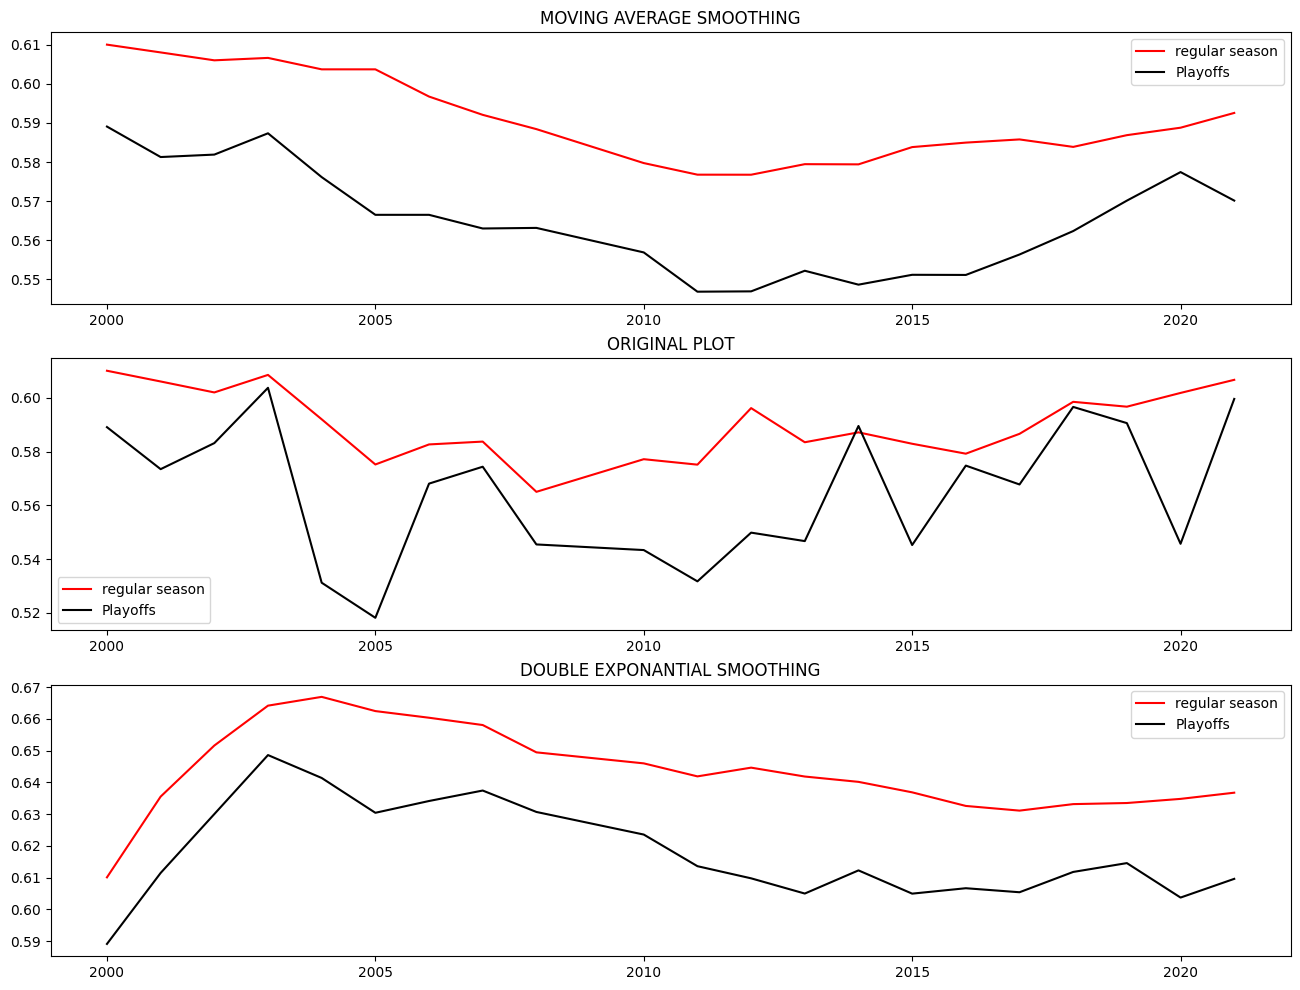

In [47]:
fig,ax = subplots(3,1,figsize=(16,12))


ax[0].plot(changed_per48_df["Year"],smt_ast_reg,label = "regular season",c = 'r')
ax[0].plot(play_per48["Year"],smt_ast_pl,label="Playoffs",c = "k")
ax[0].title.set_text("MOVING AVERAGE SMOOTHING")

ax[1].plot(changed_per48_df["Year"],changed_per48_df["AST%"],label = "regular season",c = 'r')
ax[1].plot(play_per48["Year"],play_per48["AST%"],label="Playoffs",c = "k")
ax[1].title.set_text("ORIGINAL PLOT")

ax[2].plot(changed_per48_df["Year"],exp_reg,label = "regular season",c = 'r')
ax[2].plot(play_per48["Year"],exp_pl,label="Playoffs",c = "k")
ax[2].title.set_text("DOUBLE EXPONANTIAL SMOOTHING")
ax[0].legend()
ax[1].legend()
ax[2].legend()
show()

From the Emre's presentation on plotly, I decided to give it a go.

In [48]:
fig = go.Figure()
for col in changed_per48_df.columns[1:]:
  fig.add_trace(go.Scatter(x = changed_per48_df["Year"],y = changed_per48_df[col],name=col))

fig.show ()


Although it can give all the plots in one go, I don't think it is that useful because it is not much customizable as far as I can find. so I'll keep using matplotlib so on!

# Experiments:

In [103]:
#important columns:
col = ["GP","MIN","FGM","FGA","FG3M","FG3A","FTM","FTA","OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS"]
#the other columns will create a chaos as they are percentage stats

In [104]:
#regular season data, add 1 if a player has played over 5 years else 0:
name = Regular_data.groupby(["Year","PLAYER","Rookie"])[col].sum().reset_index()

In [105]:
name

,Year,PLAYER,Rookie,GP,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2000,A.C. Green,Non-Rookie,82,1411,144,324,0,6,79,111,107,206,313,39,30,8,45,119,367
1,2000,A.J. Guyton,Rookie,33,630,78,192,27,69,15,18,10,26,36,64,9,5,24,35,198
2,2000,Aaron McKie,Non-Rookie,76,2394,338,714,53,170,149,194,33,278,311,377,106,8,203,178,878
3,2000,Aaron Williams,Non-Rookie,82,2336,297,650,0,2,244,310,211,379,590,88,59,113,132,319,838
4,2000,Adam Keefe,Non-Rookie,67,836,64,159,1,3,39,63,90,119,209,36,28,20,40,102,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9742,2021,Zach Collins,Non-Rookie,28,502,76,155,14,41,52,65,46,107,153,61,13,23,45,67,218
9743,2021,Zach LaVine,Non-Rookie,67,2328,565,1186,185,475,320,375,22,286,308,303,41,23,171,120,1635
9744,2021,Zavier Simpson,Non-Rookie,4,174,19,52,1,8,5,5,2,19,21,30,5,4,10,15,44
9745,2021,Zeke Nnaji,Non-Rookie,41,698,96,186,37,80,41,65,56,91,147,17,16,13,23,79,270


In [106]:
over5= name.groupby("PLAYER")[col].sum().reset_index()
over5["More5?"] = np.NaN
over5 = over5.sort_values("PLAYER")

In [107]:
x = (name["PLAYER"].value_counts()).sort_index()
x

A.C. Green             1
A.J. Guyton            2
AJ Hammons             1
AJ Price               5
Aaron Brooks           9
                      ..
Zion Williamson        2
Zoran Dragic           1
Zoran Planinic         3
Zydrunas Ilgauskas    10
Zylan Cheatham         1
Name: PLAYER, Length: 2066, dtype: int64

In [108]:
for y,xx in enumerate(x):
  if xx >= 5:
    over5["More5?"][y] = 1
  else:
    over5["More5?"][y] = 0
#With this, we obtain whether a player has played more than 5 years
#HOWEVER first couple of years creates noise as veteran players from these year might retire before I count!

<ipython-input-108-70ee227cb7fb>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-108-70ee227cb7fb>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
X = over5[over5.columns[1:-1]]
Y = np.array(over5["More5?"])
XXX = np.array(X)

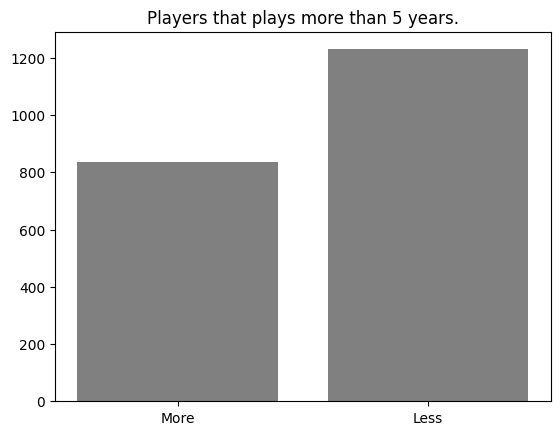

In [110]:
o5 =0
u5=0
for y in range(len(over5["More5?"])):
  if over5["More5?"][y] == 1:
    o5 +=1
  else:
    u5 +=1
rat = np.array([o5,u5])
ou = ["More","Less"]
bar(ou,rat,color = 'gray')
title("Players that plays more than 5 years.")
show()

In [111]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [112]:
xtr,xts,ytr,yts = train_test_split(XXX,Y,shuffle= True,train_size = 0.8,random_state= 43)

In [113]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(XXX,Y)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [114]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc0 =nn.Linear(32,64)
    self.fc2 = nn.Linear(64,128)
    self.fc3 = nn.Linear(128,1)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc0(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [130]:
#hyper parameters
learning_rate = 0.15
epochs = 60
# Model , Optimizer, Loss
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [132]:
#forward loop
losses = []
accur = []
print(learning_rate)
print(epochs)
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(xtr,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == ytr).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%5 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

0.15
60
epoch 0	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 5	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 10	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 15	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 20	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 25	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 30	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 35	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 40	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 45	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 50	loss : 27.77777862548828	 accuracy : 0.6071428571428571
epoch 55	loss : 27.77777862548828	 accuracy : 0.6071428571428571


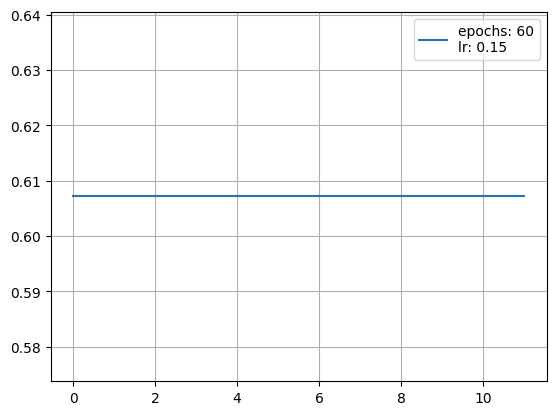

In [133]:
plot(accur,label=f"epochs: {epochs}\nlr: {learning_rate}")
legend()
grid(True)

I've tried this with numerous hyperparameter values, most logical guess is its final status but I am not sure how accurate this is as a trained model! I was not expecting a high accuracy value as it is not well defined dataset for this job, there are some players falsely labelled as they did not play after 2005 season like Micheal Jordan, he played more than 5 years but in this dataset it can not be seen. As well as that, there is one another major problem for this task: It is not balanced dataset so it affects the result.

In [79]:
xtr.shape[1]

17